# Assignment

Use the "from the expert" (FTE) jupyter notebook as a starter for this assignment, and ask your instructor questions if you need help.

Use our saved churn data from week 2 with machine learning to predict if customers will churn or not, similar to what we did in the FTE:

- break up data into features and targets
- split data into train and test sets
- use at least one ML model to fit to the training data
- evaluate performance on the train and test sets: at least evaluate accuracy and compare it with the "no information rate"
- plot a confusion matrix
- write something describing how the ML algorithm could be used in a business setting
- Write a short summary of what you did with the overall process - describe any important EDA findings, data cleaning and preparation, modeling, and evaluation in your summary.

*Optional*: For an addition challenge, try the following:
- fit more ML models and compare their scores
- optimize the hyperparameters of your models
- examine more metrics such as the classification report and ROC/AUC
- plot the distribution of the probability predictions (from the `predict_proba()` function from our model) for each class (1s and 0s)

### DS process status

Here is our data science process, and where we are (#4):

**1. Business understanding**

Can we use machine learning to predict if a customer will churn before they leave?

**2. Data understanding**

Week 1 - EDA and visualization.

**3. Data preparation**

Last week - cleaning and feature engineering.


**4. Modeling**

This week.
Fit a ML model to the data.


**5. Evaluation**

This week.
Check the performance of our models and evaluate how it fits our goals from step 1.


**6. Deployment**

This week.
Describe how the model might be deployed and used at the business. Will there be an API that customer service reps can use when customers call? Should there be a system where a report gets sent to someone in customer retention or marketing with at-risk customers? We should really think about these things in the first step, although we can consider them here this time.

In [1]:
import pandas as pd
churn_raw = pd.read_csv('../Week 2/churn_data.csv')

In [2]:
# So I forgot to fill the missing values of TotalCharges last week so here is my new class
#     to clean the data. I'm filling them with the mode of TotalCharges, since it's so 
#     skewed I figured that would be the most likely value for it to be.
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
# I hate having to rerun multiple cells though, so
class InitAttributeCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
            return self # Nothing to do here, apparently
    def transform(self, X, y=None):        
        
        ### customerID : DROP
        X = X.drop(['customerID'], axis=1).copy()

        
        ### New column : average charge
        # Fill TotalCharges with the mode of the dataset because it's so heavily skewed
        X['TotalCharges'] = X['TotalCharges'].fillna(X['TotalCharges'].mode().iloc[0]).copy()
        
        X['average_charge'] = X['TotalCharges'] / X['tenure']
        
        # We've got some infs here so we're going to replace our nulls with our average average charge
        X.loc[X['average_charge'] == np.inf, 'average_charge'] = 0#X['average_charge'].mean()
        
        # Now normalize
        # Create new normalized column
        X['average_charge_normal'] = ((X['average_charge'] - X['average_charge'].min()) /
                            (X['average_charge'].max() - X['average_charge'].min()))

        # Drop old column
        X = X.drop(['average_charge'], axis=1)


        ### tenure : bins
        X['tenure_bins'] = pd.qcut(X['tenure'], q=10, labels=[i for i in range(0,10)]).cat.codes
        X = X.drop(['tenure'], axis=1)
        
        
        ### PhoneService : binarize
        # Get our binary column
        phoneservice_binary = pd.get_dummies(X['PhoneService'], drop_first=True, prefix='PhoneService')
        
        # Concatenate it with our dataframe
        X = pd.concat([X, phoneservice_binary], axis=1)
        
        # and now drop the column that's been processed
        X = X.drop(['PhoneService'], axis=1)

        
        ### Contract : onehotencode
        # get our dummy columns
        contract_dummies = pd.get_dummies(X['Contract'], drop_first=True, prefix='Contract')

        # Concat them with our dataframe
        X = pd.concat([X, contract_dummies], axis=1)

        # and now drop the column
        X = X.drop(['Contract'], axis=1)

        
        # PaymentMethod : onehotencode
        # get our dummy columns
        paymentmethod_dummies = pd.get_dummies(X['PaymentMethod'], drop_first=True, prefix='PaymentMethod', columns=[''])

        # Concat them with our dataframe
        X = pd.concat([X, paymentmethod_dummies], axis=1)

        # and now drop the column
        X = X.drop(['PaymentMethod'], axis=1)

        
        ### MonthlyCharges : normalize
        # Create new normalized column
        X['MonthlyCharges_normal'] = ((X['MonthlyCharges'] - X['MonthlyCharges'].min()) /
                            (X['MonthlyCharges'].max() - X['MonthlyCharges'].min()))

        # Drop old column
        X = X.drop(['MonthlyCharges'], axis=1)

            
        ### TotalCharges : apply log
        
        
        # apply log
        totalcharges_log = X['TotalCharges'].apply(np.log)
        
        # change name before concat
        totalcharges_log = totalcharges_log.rename('TotalCharges_log')
        
        #concat
        X = pd.concat([X, totalcharges_log], axis=1)
        
        #drop old
        X = X.drop(['TotalCharges'], axis=1)
        
        
        ### Churn : binarize
        # Get dummy
        churn_binary = pd.get_dummies(X['Churn'], drop_first=True, prefix='Churn')

        #combine
        X = pd.concat([X, churn_binary], axis=1)

        #drop
        X = X.drop(['Churn'], axis=1)
        return X

In [3]:
cleaner = InitAttributeCleaner()
churn = cleaner.fit_transform(churn_raw.copy()).copy()
# churn.info()

In [4]:
# Breakup data into features and targets
X = churn.drop(['Churn_Yes'], axis=1).copy()
y = churn['Churn_Yes']

In [5]:
# Split data into features and targets
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, test_index in splitter.split(X, y):
    X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [6]:
# Alright well let's pick some models
#     Random Forest is a classic so we'll try that one
#     I know of the SGDClassifier - Stochastic Gradient Descent optimization of a linear
#         classifier
#     And why don't we use Naive Bayes since that's a classic 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

rf_model = RandomForestClassifier(random_state=42)
sgd_model = SGDClassifier(random_state=42)
nb_model = GaussianNB()

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 4403 to 5866
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   average_charge_normal                  5634 non-null   float64
 1   tenure_bins                            5634 non-null   int8   
 2   PhoneService_Yes                       5634 non-null   uint8  
 3   Contract_One year                      5634 non-null   uint8  
 4   Contract_Two year                      5634 non-null   uint8  
 5   PaymentMethod_Credit card (automatic)  5634 non-null   uint8  
 6   PaymentMethod_Electronic check         5634 non-null   uint8  
 7   PaymentMethod_Mailed check             5634 non-null   uint8  
 8   MonthlyCharges_normal                  5634 non-null   float64
 9   TotalCharges_log                       5634 non-null   float64
dtypes: float64(3), int8(1), uint8(6)
memory usage: 214.6 KB


In [14]:
# We're going to optimize our hyperparameters. So we're going to use a Randomized Search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint, truncnorm

# We need to define some parameters to search for our different models
rf_search_params = {'n_estimators' : randint(50, 800),
                'max_features' : truncnorm(a=0.1, b=0.8, loc=0.5, scale=0.1),
                'min_samples_split' : uniform(0.001, 0.1),
                'max_features' : ['sqrt', 'log2', None],
                'random_state' : [42]
}

sgd_search_params = {
    'alpha' : uniform(0.0001, 0.05),
    'max_iter' : randint(750, 2000),
    'loss' : ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty' : ['l2', 'l1', 'elasticnet'],
    'learning_rate' : ['optimal', 'invscaling', 'adaptive'],
    'eta0' : uniform(0.001, 0.1),
    'random_state' : [42]
    
}

# Naive Bayes doesn't have any hyperparameters to tune

In [31]:
# Let's tune our RandomForest
rf_rscv = RandomizedSearchCV(rf_model, rf_search_params, n_iter=1500, cv=2,
                             n_jobs=-1, scoring='accuracy')
rf_rscv.fit(X_train, y_train)

rf_best = rf_rscv.best_estimator_

KeyboardInterrupt: 

In [ ]:
#And now the SGD
sgd_rscv = RandomizedSearchCV(sgd_model, sgd_search_params, n_iter=1500, cv=2,
                              n_jobs=-1, scoring='accuracy')
sgd_rscv.fit(X_train, y_train)

sgd_best = sgd_rscv.best_estimator_

In [17]:
# and also the NB
nb_best = GaussianNB()
nb_best.fit(X_train, y_train)

GaussianNB()

In [ ]:
### Alright let's evaluate the scores on the train and test set for each

# RandomForest
rf_train_score = rf_best.score(X_train, y_train)
rf_test_score = rf_best.score(X_test, y_test)
print(f'RandomForest train score : {rf_train_score}, test score: {rf_test_score}')
for k in rf_best.get_params():
    print(f'    {k} : {rf_best.get_params()[k]}')
print('')

# SGD
sgd_train_score = sgd_best.score(X_train, y_train)
sgd_test_score = sgd_best.score(X_test, y_test)
print(f'SGD train score : {sgd_train_score}, test score: {sgd_test_score}')
for k in sgd_best.get_params():
    print(f'    {k} : {sgd_best.get_params()[k]}')
print('')

# NB
nb_train_score = nb_best.score(X_train, y_train)
nb_test_score = nb_best.score(X_test, y_test)
print(f'Naive Bayes train score : {nb_train_score}, test score: {nb_test_score}')

print('')

# No Information
ni_train_score = y_train.value_counts()[0] / (y_train.value_counts()[0] + y_train.value_counts()[1])
ni_test_score = y_test.value_counts()[0] / (y_test.value_counts()[0] + y_test.value_counts()[1])
print(f'No Information train score : {ni_train_score}, test score: {ni_test_score}')

print('')

AttributeError: 'RandomForestClassifier' object has no attribute 'coeff_'

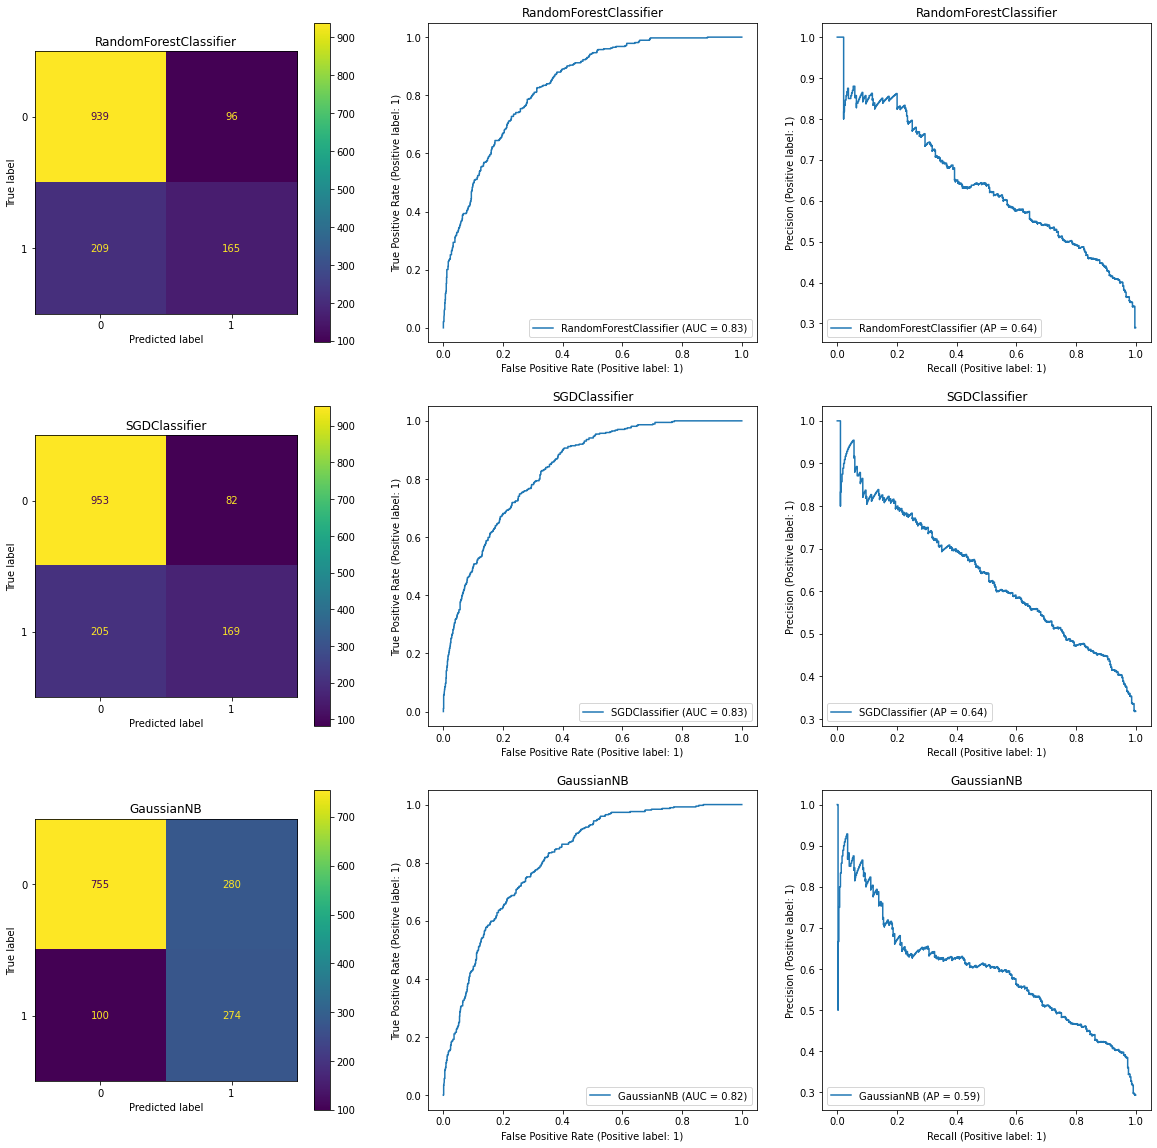

In [19]:
# Now let's check out some confustion matrices...
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20,20))

plot_confusion_matrix(rf_best, X_test, y_test, ax=axs[0,0])
plot_roc_curve(rf_best, X_test, y_test, ax=axs[0,1])
plot_precision_recall_curve(rf_best, X_test, y_test, ax=axs[0,2])
axs[0,0].title.set_text(type(rf_best).__name__)
axs[0,1].title.set_text(type(rf_best).__name__)
axs[0,2].title.set_text(type(rf_best).__name__)

plot_confusion_matrix(sgd_best, X_test, y_test, ax=axs[1,0])
plot_roc_curve(sgd_best, X_test, y_test, ax=axs[1,1])
plot_precision_recall_curve(sgd_best, X_test, y_test, ax=axs[1,2])
axs[1,0].title.set_text(type(sgd_best).__name__)
axs[1,1].title.set_text(type(sgd_best).__name__)
axs[1,2].title.set_text(type(sgd_best).__name__)

plot_confusion_matrix(nb_best, X_test, y_test, ax=axs[2,0])
plot_roc_curve(nb_best, X_test, y_test, ax=axs[2,1])
plot_precision_recall_curve(nb_best, X_test, y_test, ax=axs[2,2])
axs[2,0].title.set_text(type(nb_best).__name__)
axs[2,1].title.set_text(type(nb_best).__name__)
axs[2,2].title.set_text(type(nb_best).__name__)

In [ ]:
pd.DataFrame(rf_best.predict_proba(X_train)).hist()

# Is this just showing me that we're rarely very sure of 1 = Yes churn?

# 6. Deployment

In [ ]:
%%markdown
I think it would be interesting to use the model to try to model churn rate after making changes
to rates. You could try to use the model to extrapolate the results of changes in plans. What if
you reduced or increased all monthly rates by 10%, how might that affect churn rate? What if you
offered longer term lengths? You may have to experiment with small changes and monitor how the
mode extrapolated, for some features that aren’t current in the sample (term length?) it may not
extrapolate well.

You could also use this to direct any efforts you have towards client retention. Whether it’s
paying an employee to talk to clients or giving discounts on rates, retention plans cost money.
Since you can calculate a churn rate for existing customers, you can determine which clients are
the most efficient use of resources for the company. You could weight the chance to churn with
other variables to come up with a figure on which clients would have the best ROI on your
retention resources. Which pay the most every month? Will you focus on longer term contract
clients with high churn risk because they’re stable income? Maybe even clients that use a
certain payment method because it requires so much less cost overhead? Business needs and 
finances would dictate the way we could weight our algorithm.

# Summary
